Mounted at /content/gdrive
Dataset loaded
175 224 (224, 224, 3) 75 175 75


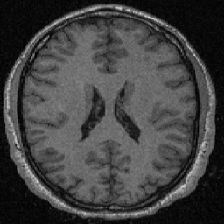

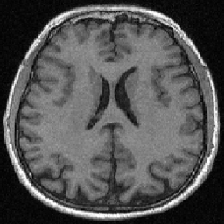

In [ ]:
import numpy as np
import cv2
import os
import re
import tensorflow
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Load dataset and preprocess
healthy_path_train = '/content/gdrive/My Drive/Colab Notebooks/dataset/train/healthy'
schizophrenia_path_train = '/content/gdrive/My Drive/Colab Notebooks/dataset/train/schizophrenia'
healthy_path_test = '/content/gdrive/My Drive/Colab Notebooks/dataset/test/healthy'
schizophrenia_path_test = '/content/gdrive/My Drive/Colab Notebooks/dataset/test/schizophrenia'

def load_dataset(healthy_path_train, schizophrenia_path_train, healthy_path_test, schizophrenia_path_test):
    images_train = []
    images_test = []
    labels_train = []
    labels_test = []
    for img in os.listdir(healthy_path_train):
        img_path = os.path.join(healthy_path_train, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        images_train.append(image)
        labels_train.append(0)
    for img in os.listdir(schizophrenia_path_train):
        img_path = os.path.join(schizophrenia_path_train, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        images_train.append(image)
        labels_train.append(1)
    for img in os.listdir(healthy_path_test):
        img_path = os.path.join(healthy_path_test, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        images_test.append(image)
        labels_test.append(0)
    for img in os.listdir(schizophrenia_path_test):
        img_path = os.path.join(schizophrenia_path_test, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        images_test.append(image)
        labels_test.append(1)
    return np.array(images_train), np.array(images_test), np.array(labels_train), np.array(labels_test)

X_train_dl, X_test_dl, y_train_dl, y_test_dl = load_dataset(healthy_path_train, schizophrenia_path_train, healthy_path_test, schizophrenia_path_test)
print("Dataset loaded")

#print(X_train_dl, X_test_dl, y_train_dl, y_test_dl)
print(len(X_train_dl),len(X_train_dl[0]), X_train_dl[0].shape, len(X_test_dl), len(y_train_dl), len(y_test_dl))

from google.colab.patches import cv2_imshow
cv2_imshow(X_train_dl[5])
cv2_imshow(X_test_dl[5])

In [ ]:
import os
import time
import numpy as np
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


X_train_dl_split, X_test_dl_split, y_train_dl_split, y_test_dl_split  = X_train_dl, X_test_dl, to_categorical(y_train_dl, num_classes=2), to_categorical(y_test_dl, num_classes=2)

print(len(X_train_dl_split),len(X_train_dl_split[0]), X_train_dl_split[0].shape, len(X_test_dl_split), len(y_train_dl_split),  len(y_test_dl_split))

def print_layer_trainable():
    for layer in base_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

# Build and compile the model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()
base_model.trainable = False

# Freeze all layers except the last 3 convolutional layers
for layer in base_model.layers[-15:]:
    layer.trainable = True

print_layer_trainable()

model = Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(2048, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation = 'relu'),
    layers.Dense(2, activation = 'softmax')
])

#model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Model Chackpoint
tl_checkpoint_h5 = ModelCheckpoint(filepath = 'vgg19_best_weights.h5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
tl_checkpoint_tf = ModelCheckpoint(filepath = 'vgg19_best_weights.tf', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')

# Define ImageDataGenerator for training data with data augmentation and other parameters
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow(X_train_dl_split, y_train_dl_split, batch_size=5)




175 224 (224, 224, 3) 75 175 75
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  

VGG19 - learning_rate=0.0001   -  1024 dropout 2048 dropout 4096

[dropout - 0.5] - Test loss: 0.291 Test accuracy: 0.906, Sensitivity(recall): 0.885, Specificity: 0.925, Precision: 0.911, F1 Score: 0.898

[[37  3]
 [ 4 31]]



Mounted at /content/gdrive
Dataset loaded
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 8s 758ms/step - loss: 3.1151 - accuracy: 0.5200 - val_loss: 0.6684 - val_accuracy: 0.5067
Epoch 2/50
7/7 [==============================] - 3s 410ms/step - loss: 1.8774 - accuracy: 0.4686 - val_loss: 0.8315 - val_accuracy: 0.4667
Epoch 3/50
7/7 [==============================] - 5s 845ms/step - loss: 1.5520 - accuracy: 0.5143 - val_loss: 0.6159 - val_accuracy: 0.6533
Epoch 4/50
7/7 [==============================] - 4s 582ms/step - loss: 1.1281 - accuracy: 0.5371 - val_loss: 0.6020 - val_accuracy: 0.7733
Epoch 5/50
7/7 [==============================] - 3s 373ms/step - loss: 0.9335 - accuracy: 0.5143 - val_loss: 0.9539 - val_accuracy: 0.5333
Epoch 6/50
7/7 [==============================] - 4s 550ms/step - loss: 0.9002 - accuracy: 0.5257 - val_loss: 0.6474 - val_accuracy: 0.6133
Epoch 7/50
7/7 [==============================] - 3s 415ms/step - loss: 0.7070 - accuracy: 0.5829 - val_loss: 0.6104 - val_accuracy: 0.7600
Epoch 8/50
7/7 [===============

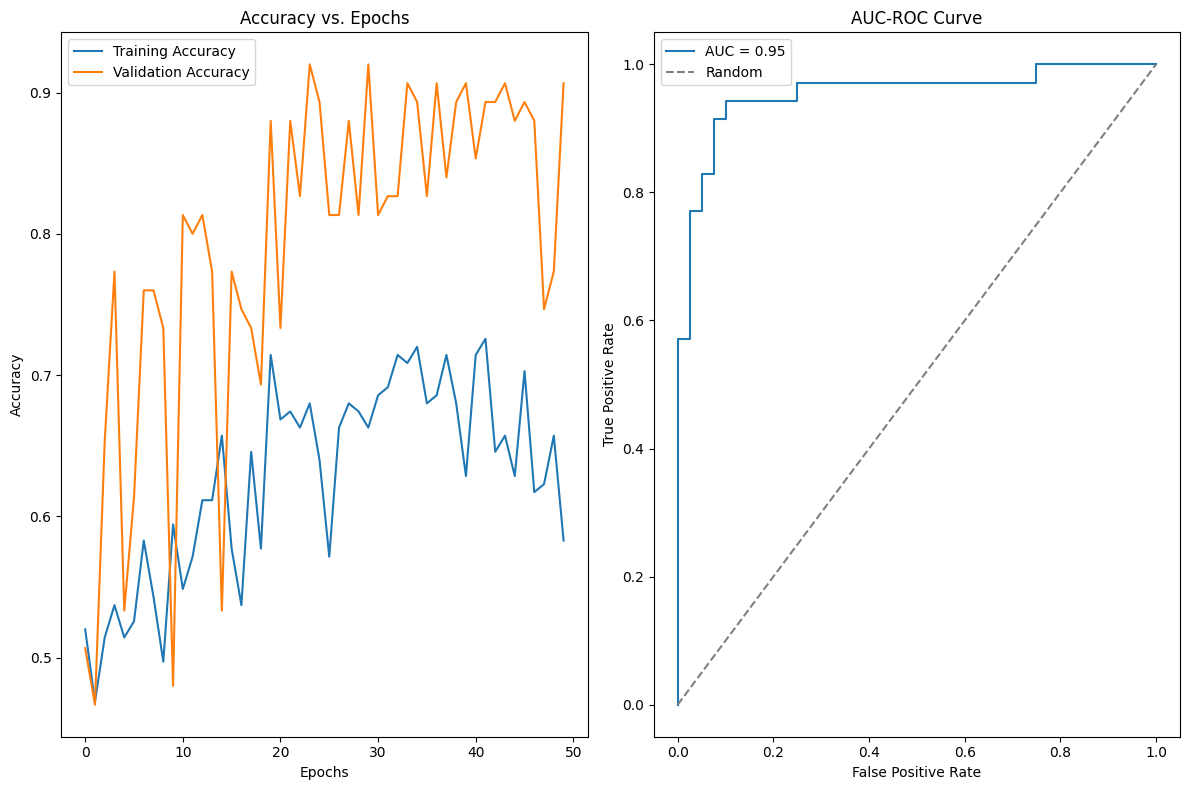

Test loss: 0.4244295060634613
Test accuracy: 0.9066666960716248
Sensitivity(recall): 0.8857142857142857
Specificity: 0.925
Precision: 0.9117647058823529
F1 Score: 0.8985507246376812
AUC-ROC Score: 0.9542857142857143
[[37  3]
 [ 4 31]]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, None, None, None   0         
                             )                                   
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, None)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              25691136  
                                                                 
 dropout_4 (Dropo

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train_dl_split) / 25,
    epochs=50,
    validation_split= 0.2,
    callbacks = [tl_checkpoint_h5,tl_checkpoint_tf]
)
# Evaluate the model
scores = model.evaluate(X_test_dl_split, y_test_dl_split, verbose=1)
y_pred_dl = model.predict(X_test_dl)
y_pred_classes = np.argmax(y_pred_dl, axis=1)
y_true_classes = np.argmax(y_test_dl_split, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
specificity = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
recall = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])

# Plot training history
plt.figure(figsize=(12, 8))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')  # Corrected ylabel to 'Accuracy'
plt.title('Accuracy vs. Epochs')
plt.legend()

# Plot AUC-ROC
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_true_classes, y_pred_dl[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Print evaluation results
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Sensitivity(recall):', recall)
print('Specificity:', specificity)
print('Precision:', precision_score(y_true_classes, y_pred_classes))
print('F1 Score:', f1_score(y_true_classes, y_pred_classes))
print('AUC-ROC Score:', roc_auc_score(y_true_classes, y_pred_dl[:, 1]))
print(conf_matrix)
model.summary()


In [ ]:
print(X_train_dl.shape, X_test_dl.shape, y_train_dl.shape, y_test_dl.shape)

# After training, load the best weights and convert to TensorFlow Lite format
best_weights_path = 'vgg19_best_weights.tf'
model.load_weights(best_weights_path)

# Convert the model to TensorFlow Lite format
converter = tensorflow.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('vgg19_best_model.tflite', 'wb') as f:
    f.write(tflite_model)



(175, 224, 224, 3) (75, 224, 224, 3) (175,) (75,)
